In [1]:
import os
import glob
import fitsio
import desimodel
import astropy
import pandas                as     pd
import pylab                 as     pl
import numpy                 as     np
import astropy.io.fits       as     fits
import matplotlib.pyplot     as     plt

from   datetime              import datetime
from   astropy.table         import Table, vstack, join
from   astropy.coordinates   import Angle, SkyCoord
from   astropy               import units as u

from   desimodel.footprint   import is_point_in_desi
from   desimodel             import io
from   desitarget.geomask    import circles
from   desitarget.targetmask import desi_mask, obsconditions
from   desitarget.io         import read_targets_in_tiles
from   desitarget.geomask    import circles
from   desimodel.focalplane  import get_tile_radius_deg 
from   desitarget.mtl        import make_mtl, mtldatamodel
from   desitarget.targets    import desi_mask, bgs_mask, mws_mask

In [49]:
desilbg_cat = Table()

In [50]:
for ttype in ['bxdrops', 'udrops', 'gdrops']:
    for file in glob.glob('/global/cscratch1/sd/mjwilson/DESILBG/final/targets/{}/*.fits'.format(ttype)):
        desilbg_cat = vstack((desilbg_cat, Table.read(file)))
        
    print('Collected {}'.format(ttype))

Collected bxdrops
Collected udrops


Collected gdrops


In [4]:
n = len(desilbg_cat)

In [5]:
n

77611

In [51]:
desilbg_cat['TARGETID'] = np.arange(n, dtype=np.int)
desilbg_cat['PRIORITY'] = np.array(desilbg_cat['PRIORITY'].data, dtype=np.int32)
 
desilbg_cat['OBSCONDITIONS'] = np.ones(n, dtype='i4') * (obsconditions.DARK + obsconditions.GRAY)

desilbg_cat['DESI_TARGET'] = np.ones(n, dtype='i8') * desi_mask.SCND_ANY
desilbg_cat['BGS_TARGET'] = np.zeros(n, dtype='i8')
desilbg_cat['MWS_TARGET'] = np.zeros(n, dtype='i8')

desilbg_cat['BRICKNAME'] = np.full(n, '000p0000')    #- required !?!
desilbg_cat['BRICKID'] = np.full(n, 0)    #- required !?!
desilbg_cat['BRICK_OBJID'] = np.arange(n)

desilbg_cat['NUMOBS_MORE'] = np.ones(n, dtype='i8')

#- dummy values for fluxes
for filt in ['G', 'R', 'Z']:
    desilbg_cat['FIBERFLUX_' + filt] = np.zeros(n, dtype='f4')
    desilbg_cat['FIBERFLUX_IVAR_' + filt] = np.ones(n, dtype='f4')
    
desilbg_cat.meta['EXTNAME'] = 'MTL'

In [52]:
desilbg_cat = desilbg_cat[desilbg_cat['PRIORITY'] >= 0]

In [53]:
for ttype in ['CLAUDS-BX', 'CLAUDS-U', 'CLAUDS-G']:
    sample = desilbg_cat[desilbg_cat['SAMPLE'] == ttype]
    
    ups, cnts = np.unique(sample['PRIORITY'], return_counts=True)
    
    for up, cnt in zip(ups, cnts):
        print(ttype, up, cnt)

CLAUDS-BX 4000 338
CLAUDS-BX 5000 57
CLAUDS-BX 6000 105
CLAUDS-BX 7000 352
CLAUDS-BX 8000 123
CLAUDS-BX 9000 462
CLAUDS-BX 10000 500
CLAUDS-BX 11000 500
CLAUDS-BX 12000 500
CLAUDS-BX 13000 500
CLAUDS-BX 14000 500
CLAUDS-BX 15000 500
CLAUDS-BX 16000 500
CLAUDS-BX 17000 500
CLAUDS-BX 18000 500
CLAUDS-BX 19000 500
CLAUDS-U 1000 107
CLAUDS-U 2000 165
CLAUDS-U 3000 500
CLAUDS-U 4000 187
CLAUDS-U 5000 500
CLAUDS-U 6000 500
CLAUDS-U 7000 500
CLAUDS-U 8000 500
CLAUDS-U 9000 500
CLAUDS-U 10000 500
CLAUDS-U 11000 500
CLAUDS-U 12000 500
CLAUDS-U 13000 500
CLAUDS-U 14000 500
CLAUDS-U 15000 500
CLAUDS-U 16000 500
CLAUDS-U 17000 500
CLAUDS-U 18000 500
CLAUDS-U 19000 500
CLAUDS-G 0 1363
CLAUDS-G 1000 463
CLAUDS-G 2000 687
CLAUDS-G 3000 771
CLAUDS-G 4000 1000
CLAUDS-G 5000 1000
CLAUDS-G 6000 1000
CLAUDS-G 7000 1000
CLAUDS-G 8000 1000
CLAUDS-G 9000 641
CLAUDS-G 10000 218


In [54]:
desilbg_cat = desilbg_cat['TARGETID', 'RA', 'DEC', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET', 'SUBPRIORITY', 'PRIORITY', 'BRICKNAME', 'BRICKID', 'BRICK_OBJID', 'OBSCONDITIONS', 'SAMPLE', 'Z_BEST', 'ZPHOT', 'FLAG_FIELD_BINARY']

In [55]:
desilbg_cat['PRIORITY_INIT'] = desilbg_cat['PRIORITY']
desilbg_cat['NUMOBS_INIT'] = np.ones(len(desilbg_cat), dtype='i8')

In [56]:
desilbg_cat

TARGETID,RA,DEC,DESI_TARGET,BGS_TARGET,MWS_TARGET,SUBPRIORITY,PRIORITY,BRICKNAME,BRICKID,BRICK_OBJID,OBSCONDITIONS,SAMPLE,Z_BEST,ZPHOT,FLAG_FIELD_BINARY [5],PRIORITY_INIT,NUMOBS_INIT
int64,float64,float64,int64,int64,int64,float64,int32,str8,int64,int64,int32,bytes9,float64,float64,bool,int32,int64
847,150.55606818069546,1.3043278997739352,4611686018427387904,0,0,0.7065797960870742,4000,000p0000,0,847,3,CLAUDS-BX,1.5434,2.1301,True .. False,4000,1
848,148.90198684660194,3.10955117323359,4611686018427387904,0,0,0.5873609950599593,4000,000p0000,0,848,3,CLAUDS-BX,2.327,2.252,True .. False,4000,1
849,149.15499699810505,2.6062028975331195,4611686018427387904,0,0,0.1345903507210222,4000,000p0000,0,849,3,CLAUDS-BX,2.6075,2.4017,True .. False,4000,1
850,149.23213555490153,2.879375784210084,4611686018427387904,0,0,0.0035513469765660055,4000,000p0000,0,850,3,CLAUDS-BX,2.4319,2.4231,True .. False,4000,1
851,149.51834557587802,1.1617281224612446,4611686018427387904,0,0,0.12179433783913474,4000,000p0000,0,851,3,CLAUDS-BX,2.264,2.2722,True .. False,4000,1
852,151.1196898541834,1.638536007716997,4611686018427387904,0,0,0.7973014522623018,4000,000p0000,0,852,3,CLAUDS-BX,2.2115,2.1873,True .. False,4000,1
853,149.2777113376859,3.222660986673207,4611686018427387904,0,0,0.970881982111072,4000,000p0000,0,853,3,CLAUDS-BX,0.0315,2.3996,True .. False,4000,1
854,150.82568809501356,2.963432574549612,4611686018427387904,0,0,0.5452515476472976,4000,000p0000,0,854,3,CLAUDS-BX,2.6404,2.6615,True .. False,4000,1
855,150.27553752318406,3.4285923811461263,4611686018427387904,0,0,0.3648533786175472,4000,000p0000,0,855,3,CLAUDS-BX,2.8475,2.7953,False .. False,4000,1


In [12]:
cra = np.mean(desilbg_cat['RA'])
cdec = np.mean(desilbg_cat['DEC'])

In [13]:
trad = get_tile_radius_deg()

In [14]:
tiles = io.load_tiles()

In [15]:
isin, indx = is_point_in_desi(tiles, desilbg_cat['RA'], desilbg_cat['DEC'], radius=None, return_tile_index=True)

In [16]:
np.unique(indx)

array([  828,  2826,  3754,  5656,  5752,  5753,  7750, 11746, 11747,
       13744, 13745, 14033])

In [17]:
tiles = Table(tiles[indx])

In [18]:
tiles = tiles[0]

In [19]:
tiles

TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS,BRIGHTRA [3],BRIGHTDEC [3],BRIGHTVTMAG [3],CENTERID,IMAGEFRAC_G,IMAGEFRAC_R,IMAGEFRAC_Z,IMAGEFRAC_GR,IMAGEFRAC_GRZ,IN_IMAGING
int32,float64,float64,int16,int16,float32,float32,float32,float32,str6,int32,float64,float64,float32,int32,float32,float32,float32,float32,float32,float32
2068,150.40735609981076,0.5742273703759129,0,1,0.029152395,1.2124556,2135.1287,1.5191989,GRAY,2,151.88892583 .. 150.631175,0.91833694 .. 1.82361361,6.9 .. 8.199,19354,0.99908054,0.99882716,0.9988285,0.9985188,0.9981242,1.0


In [20]:
tiles['RA'] = cra
tiles['DEC'] = cdec
tiles['PASS'] = 1

tiles = tiles['TILEID', 'RA', 'DEC', 'PROGRAM', 'OBSCONDITIONS', 'IN_DESI', 'PASS']

In [21]:
tiles = Table(tiles)
tiles

TILEID,RA,DEC,PROGRAM,OBSCONDITIONS,IN_DESI,PASS
int32,float64,float64,str6,int32,int16,int16
2068,150.1288392245565,2.1692518718384473,GRAY,2,1,1


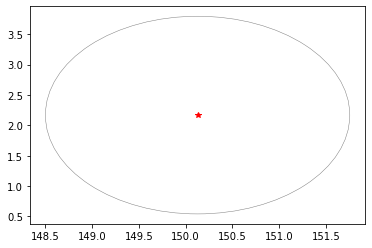

In [22]:
circles(tiles['RA'], tiles['DEC'], trad, c='k', fc='None', alpha=0.5, lw=0.5)

pl.plot(cra, cdec, marker='*', c='r')

In [23]:
tiles.write('/global/cscratch1/sd/mjwilson/DESILBG/final/survey/tiles_deslibg.fits', overwrite=True)

In [57]:
isin, indx = is_point_in_desi(tiles, desilbg_cat['RA'], desilbg_cat['DEC'], radius=None, return_tile_index=True)

In [58]:
100. * np.count_nonzero(isin) / len(desilbg_cat)

89.39639752069553

In [59]:
desilbg_cat = desilbg_cat[isin]

In [28]:
desilbg_mtl = make_mtl(desilbg_cat, 'GRAY|DARK', trimcols=True)

desilbg_mtl['SCND_TARGET'] = np.ones(len(desilbg_mtl), dtype='i8')
desilbg_mtl['NUMOBS_INIT'] = np.ones(len(desilbg_mtl), dtype='i8')
desilbg_mtl['NUMOBS_MORE'] = np.ones(len(desilbg_mtl), dtype='i8')

for nreal in np.arange(0, 1, 1):
    np.random.seed(nreal)

    desilbg_mtl['SUBPRIORITY'] = np.random.uniform(0., 1., len(desilbg_mtl))
    
    print(nreal, np.sum(desilbg_mtl['SUBPRIORITY']))
    
    desilbg_mtl.write('/global/cscratch1/sd/mjwilson/DESILBG/final/targets/desilbg_mtl_{:d}.fits'.format(nreal), overwrite=True, format='fits')

INFO:mtl.py:230:make_mtl: 21490 of 21490 targets have priority zero, setting N_obs=0.
INFO:mtl.py:293:make_mtl: Done...t=0.0s
0 10687.092526056254


In [33]:
stds  = read_targets_in_tiles('/project/projectdirs/desi/target/catalogs/dr8/0.39.0/targets/main/resolve/dark/', tiles=tiles)

In [37]:
isSTD = (stds['DESI_TARGET'] & desi_mask['STD_FAINT']) != 0
isSTD = isSTD | ((stds['DESI_TARGET'] & desi_mask['STD_BRIGHT']) != 0)
isSTD = isSTD | ((stds['DESI_TARGET'] & desi_mask['STD_WD']) != 0)

In [38]:
stds  = stds[isSTD]

In [41]:
stds = Table(stds)

In [42]:
stds

RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,RA,RA_IVAR,DEC,DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_EPOCH,WISEMASK_W1,WISEMASK_W2,MASKBITS,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEDEV_R_IVAR,SHAPEDEV_E1_IVAR,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEEXP_R_IVAR,SHAPEEXP_E1_IVAR,SHAPEEXP_E2_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,PHOTSYS,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL
int16,int32,str8,int32,str4,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,int8,float32,float32,float32,float32,float32,float32,str1,int64,int64,int64,int64,float64,int64,int64,int64,int64
8000,335291,1508p007,3482,PSF,150.87026073435052,386821900000000.0,0.8034922189904883,126087774000000.0,9040376.0 .. 0.0,0.023566248,278.71606,365.58755,386.1138,50.609116,15.689772,20.220537,0.93261683,0.954095,0.9740573,3.1176037e-07,1.2860637e-06,9.447401e-06,0.053592015,0.16902278,0.0052061547,0.99997187,0.99986553,0.9998639,4,3,3,2395.8025,656.50397,126.6028,1343.9034,341.15967,68.36983,95.435646,49.32578,43.34637,582.2732,2.6458404,0.4815627,0.0006415134,8.443259e-06,0.9960142,0.9975503,0.999477,0.99980253,0,0,0,213.56471,280.12955,295.85767,213.56471,280.12955,295.85767,2015.5,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3833617203442729728,G2,16.137299,1066.6038,16.403856,135.51567,15.699362,187.85742,1.2112389,0.0,False,0.8861208,31,0.41062286,67.78639,-16.05737,4.272141,-18.363354,1.6553545,S,35185778401217946,2305843052163366912,0,1280,0.9829050963299427,7,1500,1,27239
8000,333848,1501p005,3425,PSF,150.1051874259986,1486858600000000.0,0.5673552799321797,1147125900000000.0,3743186.8 .. 0.0,0.024925245,156.20116,219.2126,238.19025,39.175808,33.898987,20.422884,0.92887247,0.95151305,0.972582,0.0,0.0,0.0,0.0064312606,0.0053805164,0.012126187,0.99961853,0.9797779,0.6661253,2,3,2,1401.4141,662.5527,78.67051,717.2932,364.5019,46.1941,61.73685,32.090107,-1.8873316,362.29205,2.7411551,0.4964793,0.00078619807,1.0418273e-05,0.9957848,0.9974092,0.99944687,0.9997911,0,0,0,121.57964,170.62479,185.39609,121.57964,170.62479,185.39609,2015.5,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3833627369630131712,G2,16.721956,938.0726,17.03586,85.76941,16.236057,95.59431,1.215567,0.0,False,0.19388033,31,0.030343693,93.64695,-0.5346998,30.556423,-4.127793,31.855219,S,35185772348837217,2305843052163366912,0,1280,0.8524919114153144,7,1500,1,27239
8000,333849,1503p005,3641,PSF,150.3585

In [44]:
stds.write('/global/cscratch1/sd/mjwilson/DESILBG/final/targets/stds/stds_desilbg.fits', format='fits', overwrite=True)

In [18]:
skies = read_targets_in_tiles('/project/projectdirs/desi/target/catalogs/dr8/0.39.0/skies/', tiles=tiles)

In [278]:
gfas  = read_targets_in_tiles('/project/projectdirs/desi/target/catalogs/dr8/0.39.0/gfas/', tiles=tiles)

In [279]:
gfas  = Table(gfas)

In [280]:
gfas['SUBPRIORITY']   = np.random.uniform(0, 1, len(gfas))
gfas['OBSCONDITIONS'] = np.ones(len(gfas), dtype='i4') * obsconditions.DARK
gfas['DESI_TARGET']   = desi_mask.STD_FAINT

In [281]:
gfas=gfas[gfas['TARGETID'] >= 0]

In [282]:
gfas

RELEASE,TARGETID,BRICKID,BRICK_OBJID,RA,DEC,RA_IVAR,DEC_IVAR,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,REF_ID,REF_CAT,REF_EPOCH,PARALLAX,PARALLAX_IVAR,PMRA,PMDEC,PMRA_IVAR,PMDEC_IVAR,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,URAT_ID,URAT_SEP,HPXPIXEL,SUBPRIORITY,OBSCONDITIONS,DESI_TARGET
int32,int64,int32,int32,float64,float64,float32,float32,str4,float32,float32,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,int64,float64,int32,int64
8000,35185820675605962,345370,1482,150.64577188239159,2.4406430199609384,858027650.0,663117760.0,PSF,37.349262,90.36481,106.39152,31.813318,7.880392,5.4741583,244000361,T2,1991.625,0.0,0.0,4.6,-3.1999998,127551.02,118906.06,11.893,0.0,0.0,0.0,0.0,0.0,0.0,-99,-99.0,27257,0.8011359943277362,1,8589934592
8000,35185802560405756,341051,252,150.88582682267227,1.642436657780213,733761700.0,1065255800.0,PSF,49.859394,46.101273,81.542915,42.840973,30.044582,12.284751,244007261,T2,1991.74,0.0,0.0,-48.7,20.300001,118906.06,147929.0,11.757,0.0,0.0,0.0,0.0,0.0,0.0,-99,-99.0,27256,0.8934941278705506,1,8589934592
8000,35185820688189421,345373,2029,151.30821043202545,2.5034946765182293,7823771600.0,5672170000.0,PSF,12160.119,49652.723,18191.316,0.0071901074,0.003369988,0.0027330364,247000021,T2,1991.6699,0.0,0.0,40.600002,-86.1,694444.4,694444.4,10.526,0.0,0.0,0.0,0.0,0.0,0.0,-99,-99.0,27257,0.44967727589764317,1,8589934592
8000,35185820671415169,345369,4993,150.37674342013227,2.604357659982102,4237939700.0,2563691800.0,PSF,20307.102,29004.303,10919.071,0.015598972,0.0077963937,0.006863946,247000601,T2,1991.44,0.0,0.0,-34.600002,6.6,346020.75,308642.0,11.076,0.0,0.0,0.0,0.0,0.0,0.0,-99,-99.0,27259,0.8906924356762166,1,8589934592
8000,35185832763589786,348252,1178,151.1573548396282,2.943814629548075,1223979800.0,622403900.0,PSF,-0.43598965,2.9669113,5.1432548,217.4261,50.941643,20.946547,247014551,T2,1991.655,0.0,0.0,-51.7,6.5,137174.2,118906.06,12.0,0.0,0.0,0.0,0.0,0.0,0.0,-99,-99.0,27257,0.9691234582626669,1,8589934592
8000,35185772353032148,333849,4052,150.47004694028806,0.5941707986969181,47630097000000.0,29127160000000.0,PSF,32.313305,57.11468,70.94632,275.09753,76.75252,43.579887,3833583595323656192,G2,2015.5,0.15102151,8.449016,2.609444,-4.319082,1.7625748,0.9127424,18.299976,335.15485,18.627842,26.442356,17.60298,49.452515,0.0,-99,-99.0,27239,0.4152731239266114,1,8589934592
8000,35185772357227118,333850,4718,150.50299448542532,0.6023058070049063,46301723000000.0,102682610000000.0,PSF,2.2333755,9.731335,75.579384,1158.0974,314.11456,59.291363,3833607028665226240,G2,2015.5,1.7560444,2.0995522,-2.000868,4.8951054,1.6932788,1.9958805,19.506798,178.77809,21.64139,6.273142,18.232414,42.287807,0.0,-99,-99.0,27239,0.7852789654220628,1,8589934592
8000,35185772353032250,333849,4154,150.4864659441625,0.5983619573534122,29966012000000.0,119225360000000.0,PSF,5.478841,21.582912,54.801865,852.09564,158.99939,63.607407,3833607063024962816,G2,2015.5,0.87622523,1.3459541,-81.03003,-55.1723,1.9438444,2.0688212,19.22287,236.80893,20.189518,9.151334,18.230669,41.131794,0.15608715,-99,-99.0,27239,0.528672154234866,1,8589934592
8000,35185772357227454,333850,5054,150.5160759192758,0.6178112453831867,5366330000000000.0,7503186000000000.0,PSF,522.10175,813.00244,914.08923,29.649288,13.551857,5.441247,3833607170399090688,G2,2015.5,0.697692,314.06693,-0.37623322,1.6068532,159.83246,192.578,15.328591,2010.7217,15.691347,280.39514,14.812709,378.80737,0.062157266,-99,-99.0,27239,0.2019416715881014,1,8589934592


In [36]:
fitsio.write('/global/cscratch1/sd/mjwilson/DESILBG/final/targets/skies/skies_desilbg.fits', skies)

In [87]:
gfas.write('/global/cscratch1/sd/mjwilson/DESILBG/final/targets/gfas/gfas_desilbg.fits', format='fits', overwrite=True)

In [39]:
gfas = fitsio.read('/global/cscratch1/sd/mjwilson/DESILBG/final/targets/gfas/gfas_desilbg.fits')
skies = fitsio.read('/global/cscratch1/sd/mjwilson/DESILBG/final/targets/skies/skies_desilbg.fits')

In [29]:
rundatestr = "2020-12-01T00:00:00"
rundate    = datetime.strptime(rundatestr, "%Y-%m-%dT%H:%M:%S")

rundate

datetime.datetime(2020, 12, 1, 0, 0)

In [30]:
fp, exclude, state, tmstr = desimodel.io.load_focalplane(time=rundate)

In [31]:
ra, dec = desimodel.focalplane.xy2radec(tiles['RA'], tiles['DEC'], fp['OFFSET_X'], fp['OFFSET_Y'])

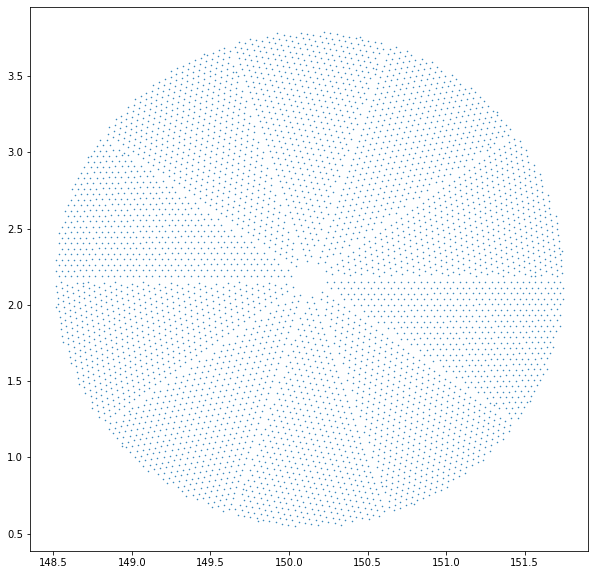

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(ra, dec, '.', markersize=1)

In [33]:
for nreal in np.arange(0, 1, 1):
    print('Assigning realization {:d}'.format(nreal))
    
    cmd  = 'fiberassign --overwrite --mtl /global/cscratch1/sd/mjwilson/DESILBG/final/targets/desilbg_mtl_{:d}.fits'.format(nreal) 
    cmd += ' --gfafile /global/cscratch1/sd/mjwilson/DESILBG/final/targets/gfas/gfas_desilbg.fits' 
    cmd += ' --sky /global/cscratch1/sd/mjwilson/DESILBG/final/targets/skies/skies_desilbg.fits'
    cmd += ' --stdstar /global/cscratch1/sd/mjwilson/DESILBG/final/targets/stds/stds_desilbg.fits'
    cmd += ' --rundate {}'.format(rundatestr)
    cmd += ' --footprint /global/cscratch1/sd/mjwilson/DESILBG/final/survey/tiles_deslibg.fits'
    cmd += ' --outdir /global/cscratch1/sd/mjwilson/DESILBG/final/fiberassign/{:d}/'.format(nreal)
    
    os.system(cmd)

Assigning realization 0


In [34]:
fa = fits.open('/global/cscratch1/sd/mjwilson/DESILBG/final/fiberassign/0/fiberassign-011155.fits')

In [35]:
fa.info()

Filename: /global/cscratch1/sd/mjwilson/DESILBG/final/fiberassign/0/fiberassign-011155.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   ()      
  1  FIBERASSIGN    1 BinTableHDU    173   5000R x 68C   [K, I, J, J, J, J, D, D, E, E, E, E, E, E, K, B, 3A, E, E, I, J, D, J, K, K, K, K, K, 8A, J, J, E, E, E, 4A, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, E, E, E, K, 2A, E, E, E, E, 1A, J, E, E, E, E, K]   
  2  SKY_MONITOR    1 BinTableHDU     85   20R x 24C   [J, J, I, K, J, J, K, B, D, D, E, E, 8A, J, I, J, J, D, E, E, E, E, E, E]   
  3  GFA_TARGETS    1 BinTableHDU    119   919R x 41C   [J, K, J, J, D, D, E, E, 4A, E, E, E, E, E, E, K, 2A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, K, E, K, D, J, K, I, I, I, I]   
  4  TARGETS       1 BinTableHDU    173   5020R x 68C   [K, I, J, J, J, J, D, D, E, E, E, E, E, E, K, B, 3A, E, E, I, J, D, J, K, K, K, K, K, 8A, J, J, E, E, E, 4A, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E

In [36]:
fa_fiberassign = Table(fa[1].data)
sky_monitor = Table(fa[2].data)
gfa_targets = Table(fa[3].data)
fa_targets = Table(fa[4].data)
fa_potential = Table(fa[5].data)

In [37]:
fa_fiberassign 

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,PMRA_IVAR,PMDEC_IVAR,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,NUMTARGET,PRIORITY,SUBPRIORITY,OBSCONDITIONS,DESI_TARGET,BGS_TARGET,MWS_TARGET,PRIORITY_INIT,NUMOBS_INIT,BRICKNAME,BRICKID,BRICK_OBJID,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_W1,FLUX_W2,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,FRACDEV,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,RELEASE,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,HPXPIXEL
int64,int16,int32,int32,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int64,uint8,str3,float32,float32,int16,int32,float64,int32,int64,int64,int64,int64,int64,str8,int32,int32,float32,float32,float32,str4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,str1,int32,float32,float32,float32,float32,int64
60535,0,311,311,0,0,149.78839548168472,1.0344582063125494,0.0,0.0,0.0,0.0,0.0,5400.0,4611686018427387904,1,TGT,80.48639,-286.37064,0,0,0.7663105859832143,63,0,0,0,0,0,,0,0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,0,0.0,0.0,0.0,0.0,0
13168,0,272,272,1,0,149.8779341651556,1.0925382646189965,0.0,0.0,0.0,0.0,0.0,5400.0,4611686018427387904,1,TGT,58.01872,-271.12823,0,0,0.8921982110925353,63,4611686018427387904,0,0,19000,1,,0,0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,0,0.0,0.0,0.0,0.0,0
611646536727659547,0,252,252,2,0,149.9963789129633,1.0990843799825223,0.0,0.0,0.0,0.0,0.0,5400.0,4294967296,4,SKY,28.613544,-269.2895,0,0,0.3959258746268626,63,4294967296,0,0,0,-1,1498p010,336727,1051,-0.016099926,-0.038256615,0.05709812,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,8000,24.27243,4538.3115,1168.776,168.52444,27245
22784,0,156,156,3,0,150.10100779552124,1.2848823104163714,0.0,0.0,0.0,0.0,0.0,5400.0,4611686018427387904,1,TGT,2.6206079,-221.85275,0,0,0.00511677256246168,63,0,0,0,0,0,,0,0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,0,0.0,0.0,0.0,0.0,0
64897,0,198,198,4,0,150.18924912353393,1.1636297314715516,0.0,0.0,0.0,0.0,0.0,5400.0,4611686018427387904,1,TGT,-19.148827,-252.74081,0,0,0.4830825813905484,63,0,0,0,0,0,,0,0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,0,0.0,0.0,0.0,0.0,0
48941,0,204,204,5,0,149.93630595172723,1.2178181674394797,0.0,0.0,0.0,0.0,0.0,5400.0,4611686018427387904,1,TGT,43.300495,-238.94037,0,0,0.6602003727372155,63,0,0,0,0,0,,0,0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,0,0.0,0.0,0.0,0.0,0
611646536731853946,0,233,233,6,0,150.05945146725406,1.109638862418631,0.0,0.0,0.0,0.0,0.0,5400.0,4294967296,4,SKY,12.97463,-266.54312,0,0,0.9022199193676411,63,4294967296,0,0,0,-1,1501p010,336728,1146,-0.03350693,0.02036558,-0.07832674,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,8000,36.8189,4594.491,1286.9491,171.4528,27245
611646542771651255,0,172,172,7,0,150.029383226648,1.263644074028763,0.0,0.0,0.0,0.0,0.0,5400.0,4294967296,4,SKY,20.275194,-227.23427,0,0,0.7821648418472154,63,4294967296,0,0,0,-1,1501p012,338168,695,0.0026422914,-0.056003258,-0.06932737,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,8000,29.514696,4440.191,1272.6793,167.04399,27245
22204,0,310,310,8,0,149.81675190994798,1.0153237136226232,0.0,0.0,0.0,0

In [40]:
np.count_nonzero(np.isin(fa_fiberassign['TARGETID'], skies['TARGETID']))

2234

In [41]:
assigned_gfas = gfas[np.isin(gfas['TARGETID'], fa_fiberassign['TARGETID'])]

In [42]:
assigned = desilbg_cat[np.isin(desilbg_cat['TARGETID'], fa_fiberassign['TARGETID'])]

In [43]:
np.count_nonzero(np.isin(fa_potential['TARGETID'], desilbg_cat['TARGETID']))

1281

In [44]:
ufiber, cnts = np.unique(fa_potential[np.isin(fa_potential['TARGETID'], desilbg_cat['TARGETID'])]['FIBER'], return_counts=True)

Text(0.5, 0, 'Fiber conflicts')

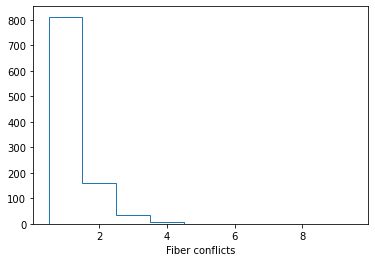

In [45]:
bins = np.arange(0.5, 10.5, 1.0)

pl.hist(cnts, bins=bins, histtype='step')

pl.xlabel('Fiber conflicts')

In [46]:
assigned_sky = fa_fiberassign[fa_fiberassign['OBJTYPE'] == 'SKY']

In [47]:
len(assigned_sky)

2229

In [60]:
assigned_desilbgs = desilbg_cat[np.isin(desilbg_cat['TARGETID'], fa_fiberassign['TARGETID'])]

assigned_gdrops  = assigned_desilbgs[assigned_desilbgs['SAMPLE'] == 'CLAUDS-G']
assigned_udrops  = assigned_desilbgs[assigned_desilbgs['SAMPLE'] == 'CLAUDS-U']
assigned_bxdrops = assigned_desilbgs[assigned_desilbgs['SAMPLE'] == 'CLAUDS-BX']

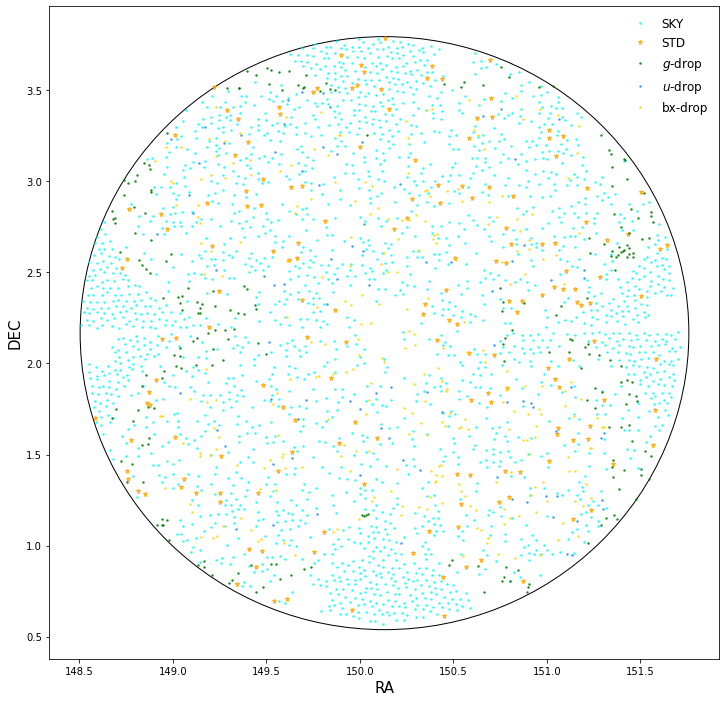

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))

plt.sca(ax)

circles(tiles['RA'], tiles['DEC'], trad, c='k', fc='w')

ax.plot(assigned_sky['TARGET_RA'], assigned_sky['TARGET_DEC'], marker='.', lw=0.0, markersize=3, c='cyan', alpha=0.75, label='SKY')
ax.plot(assigned_gfas['RA'], assigned_gfas['DEC'], marker='*', lw=0.0, markersize=5, c='orange', alpha=0.75, label='STD')
ax.plot(assigned_gdrops['RA'], assigned_gdrops['DEC'], marker='.', lw=0.0, markersize=3, c='green', alpha=0.75, label='$g$-drop')
ax.plot(assigned_udrops['RA'], assigned_udrops['DEC'], marker='.', lw=0.0, markersize=3, c='dodgerblue', alpha=0.75, label='$u$-drop')
ax.plot(assigned_bxdrops['RA'], assigned_bxdrops['DEC'], marker='.', lw=0.0, markersize=3, c='gold', alpha=0.75, label='bx-drop')

ax.set_xlabel('RA', fontsize=15)
ax.set_ylabel('DEC', fontsize=15)

ax.legend(frameon=False, fontsize=12)

In [62]:
np.unique(assigned_sky['PETAL_LOC'], return_counts=True)

(<Column name='PETAL_LOC' dtype='int16' length=10>
 0
 1
 2
 3
 4
 5
 6
 7
 8
 9,
 array([294, 177, 221, 247, 218, 308, 204, 212, 208, 140]))

In [63]:
len(assigned_gdrops), len(assigned_udrops), len(assigned_bxdrops)

(237, 87, 278)

In [518]:
def completeness(real, sample):
    fa = fits.open('/global/cscratch1/sd/mjwilson/DESILBG/final/fiberassign/{:d}/fiberassign-011155.fits'.format(real))
    fa_fiberassign = Table(fa[1].data)

    assigned = desilbg_cat[np.isin(desilbg_cat['TARGETID'], fa_fiberassign['TARGETID'])]
    assignable = desilbg_cat [np.isin(desilbg_cat['TARGETID'], fa_potential['TARGETID'])]
    
    ups = np.unique(desilbg_cat[desilbg_cat['SAMPLE'] == sample]['PRIORITY'])
    
    result = np.array([100. * len(assigned[(assigned['PRIORITY'] == up) & (assigned['SAMPLE'] == sample)]) / len(assignable[(assignable['PRIORITY'] == up) & (assignable['SAMPLE'] == sample)]) for up in ups])
    
    return ups, result

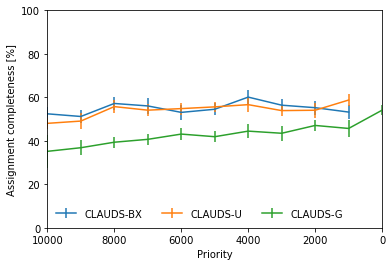

In [605]:
for sample in ['CLAUDS-BX', 'CLAUDS-U', 'CLAUDS-G']:
    results = []
    
    for real in np.arange(50):
        ups, result = completeness(real, sample=sample)

        results.append(result.tolist())
    
    results = np.array(results)

    pl.errorbar(ups, results.mean(axis=0), results.std(axis=0), label=sample)

pl.xlim(10000, 0)
pl.ylim(0., 100.)

pl.xlabel('Priority')
pl.ylabel('Assignment completeness [%]')

pl.legend(frameon=False, ncol=3, loc=3)

In [557]:
def pzs(real):
    fa = fits.open('/global/cscratch1/sd/mjwilson/DESILBG/final/fiberassign/{:d}/fiberassign-011155.fits'.format(real))
    fa_fiberassign = Table(fa[1].data)

    assigned = desilbg_cat[np.isin(desilbg_cat['TARGETID'], fa_fiberassign['TARGETID'])]
    assignable = desilbg_cat [np.isin(desilbg_cat['TARGETID'], fa_potential['TARGETID'])]
        
    bins=np.arange(0.0, 5.1, 0.1)
        
    cnts, _ = np.histogram(assigned['Z_BEST'], bins=bins)
    
    return bins, cnts

Text(0.5, 0, 'Redshift')

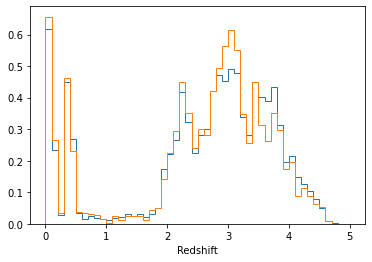

In [548]:
pl.hist(desilbg_cat['Z_BEST'], bins=np.arange(0.0, 5.1, 0.1), histtype='step', density=True)
pl.hist(assigned_desilbgs['Z_BEST'], bins=np.arange(0.0, 5.1, 0.1), histtype='step', density=True)

pl.xlabel('Redshift')

In [607]:
results = []
    
for real in np.arange(50):
    bins, cnts = pzs(real)

    results.append(cnts.tolist())
    
results = np.array(results)

In [606]:
cnts, _ = np.histogram(desilbg_cat['Z_BEST'], bins=bins)

Text(0, 0.5, 'p(z)')

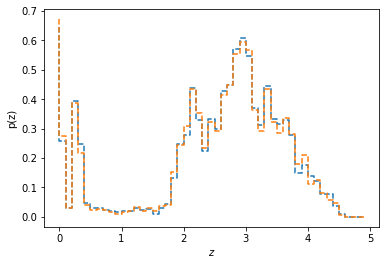

In [613]:
plt.plot(bins[:-1], cnts / 0.1 / np.sum(results.mean(axis=0)), drawstyle='steps', linestyle='--')
plt.plot(bins[:-1], results.mean(axis=0) / 0.1 / np.sum(results.mean(axis=0)), drawstyle='steps', linestyle='--')

pl.xlabel('$z$')
pl.ylabel('p(z)')

In [610]:
interloper_rate = 100. * np.count_nonzero(assigned_desilbgs['Z_BEST'] < 1.0) / len(assigned_desilbgs)
interloper_rate

17.99227799227799

In [67]:
np.unique(desilbg_cat['SAMPLE'], return_counts=True)

(<MaskedColumn name='SAMPLE' dtype='bytes9' length=3>
 CLAUDS-BX
  CLAUDS-G
  CLAUDS-U,
 array([6426, 6636, 8428]))

### Done.